# Diseño de Filtros para Sistema de Detección de Pulsos

## Especificaciones del Sistema
- **Frecuencia de muestreo real:** 2024 Hz (medida)
- **Frecuencia objetivo:** 21 Hz (detección de pulsos)
- **Ancho de banda:** ±9 Hz (12 Hz - 30 Hz)
- **Formato:** Q15 fixed-point (15 bits fraccionarios)
- **Hardware:** Arduino Nano 33 BLE (nRF52840)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import butter, iirfilter, freqz, firwin, remez

# Configuración de gráficos
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

## 1. Parámetros del Sistema

In [2]:
# Parámetros del sistema
fs = 2024  # Frecuencia de muestreo real medida
fc = 21    # Frecuencia central del filtro
bw = 18    # Ancho de banda (±9 Hz)
Q = fc / bw  # Factor de calidad

# Bandas del filtro pasa-banda
f_low = fc - bw/2   # 12 Hz
f_high = fc + bw/2  # 30 Hz

print(f"Frecuencia de muestreo: {fs} Hz")
print(f"Frecuencia central: {fc} Hz")
print(f"Ancho de banda: {bw} Hz ({f_low} Hz - {f_high} Hz)")
print(f"Factor Q: {Q:.3f}")
print(f"Frecuencia normalizada (fc/fs): {fc/fs:.6f}")

Frecuencia de muestreo: 2024 Hz
Frecuencia central: 21 Hz
Ancho de banda: 18 Hz (12.0 Hz - 30.0 Hz)
Factor Q: 1.167
Frecuencia normalizada (fc/fs): 0.010375


## 2. Diseño del Filtro IIR Pasa-Banda

Vamos a diseñar un filtro biquad IIR pasa-banda usando diferentes métodos y comparar los resultados.

In [3]:
# Método 1: Butterworth bandpass de orden 2
sos_butter = signal.butter(2, [f_low, f_high], btype='bandpass', fs=fs, output='sos')
b_butter, a_butter = signal.butter(2, [f_low, f_high], btype='bandpass', fs=fs)

print("=== Filtro Butterworth (orden 2) ===")
print(f"Coeficientes b (numerador): {b_butter}")
print(f"Coeficientes a (denominador): {a_butter}")
print(f"\nSOS (Second Order Sections):\n{sos_butter}")

=== Filtro Butterworth (orden 2) ===
Coeficientes b (numerador): [ 0.00075074  0.         -0.00150148  0.          0.00075074]
Coeficientes a (denominador): [ 1.         -3.91421378  5.75272085 -3.76251363  0.92401813]

SOS (Second Order Sections):
[[ 7.50740591e-04  1.50148118e-03  7.50740591e-04  1.00000000e+00
  -1.94193340e+00  9.48691433e-01]
 [ 1.00000000e+00 -2.00000000e+00  1.00000000e+00  1.00000000e+00
  -1.97228038e+00  9.73992274e-01]]


In [4]:
# Método 2: Diseño directo usando iirpeak/iirnotch approach
# Crear un filtro resonante en 21 Hz con Q específico
w0 = fc / (fs/2)  # Frecuencia normalizada (0 a 1, donde 1 = fs/2)
Q_design = 2.333  # Factor Q deseado

# Diseñar filtro peak (resonante) que actúa como pasa-banda estrecho
b_peak, a_peak = signal.iirpeak(w0, Q_design)

print("=== Filtro IIR Peak (Q=2.333) ===")
print(f"w0 (freq normalizada): {w0:.6f}")
print(f"Q: {Q_design}")
print(f"Coeficientes b: {b_peak}")
print(f"Coeficientes a: {a_peak}")

=== Filtro IIR Peak (Q=2.333) ===
w0 (freq normalizada): 0.020751
Q: 2.333
Coeficientes b: [ 0.0137799  0.        -0.0137799]
Coeficientes a: [ 1.         -1.96825036  0.9724402 ]


In [5]:
# Método 3: Coeficientes actuales en el código (para comparación)
# Convertir de Q15 a float
def q15_to_float(q15_val):
    return q15_val / 32768.0

# Coeficientes actuales del código
b0_q15_current = 2912
b1_q15_current = 0
b2_q15_current = -2912
a0_q15_current = 32768  # Implícito (siempre 1.0)
a1_q15_current = -64482
a2_q15_current = 31855

b_current = np.array([q15_to_float(b0_q15_current), 
                      q15_to_float(b1_q15_current), 
                      q15_to_float(b2_q15_current)])
a_current = np.array([1.0,
                      q15_to_float(a1_q15_current), 
                      q15_to_float(a2_q15_current)])

print("=== Filtro actual en el código ===")
print(f"Coeficientes b: {b_current}")
print(f"Coeficientes a: {a_current}")

=== Filtro actual en el código ===
Coeficientes b: [ 0.08886719  0.         -0.08886719]
Coeficientes a: [ 1.         -1.96783447  0.97213745]


## 3. Análisis de Respuesta en Frecuencia

C:\Users\emanu\AppData\Local\Temp\ipykernel_106056\448340339.py:10: RuntimeWarning: divide by zero encountered in log10
  ax1.plot(w_butter, 20 * np.log10(abs(h_butter)), 'b-', label='Butterworth (orden 2)', linewidth=2)
C:\Users\emanu\AppData\Local\Temp\ipykernel_106056\448340339.py:11: RuntimeWarning: divide by zero encountered in log10
  ax1.plot(w_peak, 20 * np.log10(abs(h_peak)), 'g-', label='IIR Peak (Q=2.333)', linewidth=2)
C:\Users\emanu\AppData\Local\Temp\ipykernel_106056\448340339.py:12: RuntimeWarning: divide by zero encountered in log10
  ax1.plot(w_current, 20 * np.log10(abs(h_current)), 'r--', label='Filtro actual (código)', linewidth=2)


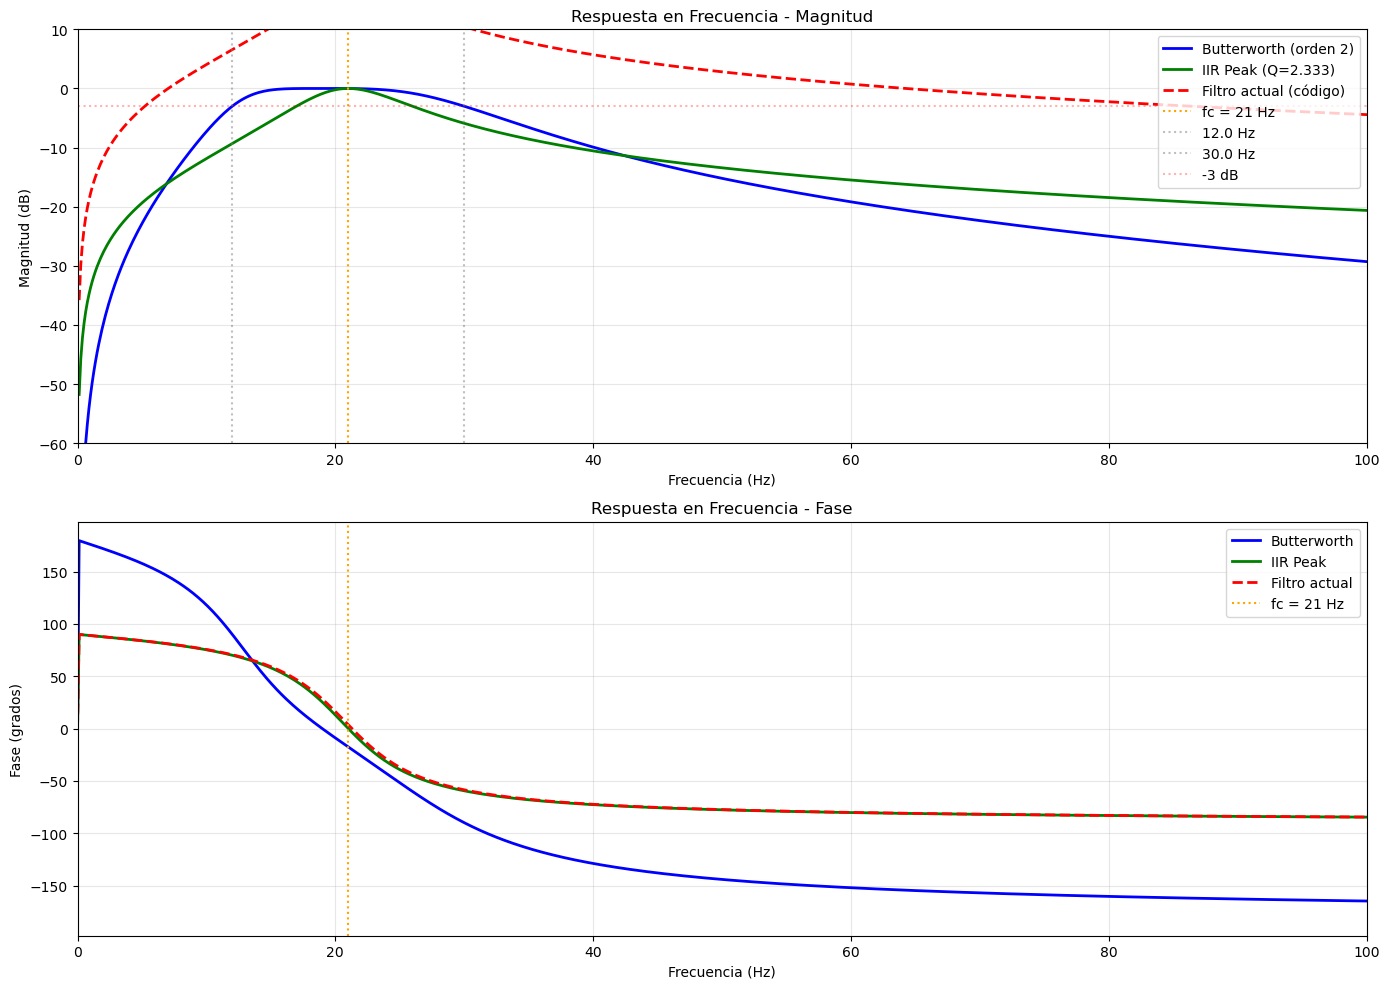


Ganancia a 21 Hz:
  Butterworth: 0.9990 (-0.01 dB)
  IIR Peak: 1.0000 (-0.00 dB)
  Filtro actual: 6.3665 (16.08 dB)


In [6]:
# Calcular respuesta en frecuencia para cada filtro
w_butter, h_butter = signal.freqz(b_butter, a_butter, worN=8000, fs=fs)
w_peak, h_peak = signal.freqz(b_peak, a_peak, worN=8000, fs=fs)
w_current, h_current = signal.freqz(b_current, a_current, worN=8000, fs=fs)

# Graficar magnitud
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Gráfico 1: Magnitud en dB
ax1.plot(w_butter, 20 * np.log10(abs(h_butter)), 'b-', label='Butterworth (orden 2)', linewidth=2)
ax1.plot(w_peak, 20 * np.log10(abs(h_peak)), 'g-', label='IIR Peak (Q=2.333)', linewidth=2)
ax1.plot(w_current, 20 * np.log10(abs(h_current)), 'r--', label='Filtro actual (código)', linewidth=2)

ax1.axvline(fc, color='orange', linestyle=':', label=f'fc = {fc} Hz')
ax1.axvline(f_low, color='gray', linestyle=':', alpha=0.5, label=f'{f_low} Hz')
ax1.axvline(f_high, color='gray', linestyle=':', alpha=0.5, label=f'{f_high} Hz')
ax1.axhline(-3, color='red', linestyle=':', alpha=0.3, label='-3 dB')

ax1.set_xlabel('Frecuencia (Hz)')
ax1.set_ylabel('Magnitud (dB)')
ax1.set_title('Respuesta en Frecuencia - Magnitud')
ax1.grid(True, alpha=0.3)
ax1.legend(loc='upper right')
ax1.set_xlim([0, 100])  # Zoom en la región de interés
ax1.set_ylim([-60, 10])

# Gráfico 2: Fase
ax2.plot(w_butter, np.angle(h_butter, deg=True), 'b-', label='Butterworth', linewidth=2)
ax2.plot(w_peak, np.angle(h_peak, deg=True), 'g-', label='IIR Peak', linewidth=2)
ax2.plot(w_current, np.angle(h_current, deg=True), 'r--', label='Filtro actual', linewidth=2)

ax2.axvline(fc, color='orange', linestyle=':', label=f'fc = {fc} Hz')
ax2.set_xlabel('Frecuencia (Hz)')
ax2.set_ylabel('Fase (grados)')
ax2.set_title('Respuesta en Frecuencia - Fase')
ax2.grid(True, alpha=0.3)
ax2.legend(loc='upper right')
ax2.set_xlim([0, 100])

plt.tight_layout()
plt.show()

# Calcular ganancia a fc para cada filtro
def get_gain_at_freq(b, a, freq, fs):
    w, h = signal.freqz(b, a, worN=[freq], fs=fs)
    return abs(h[0])

gain_butter_fc = get_gain_at_freq(b_butter, a_butter, fc, fs)
gain_peak_fc = get_gain_at_freq(b_peak, a_peak, fc, fs)
gain_current_fc = get_gain_at_freq(b_current, a_current, fc, fs)

print(f"\nGanancia a {fc} Hz:")
print(f"  Butterworth: {gain_butter_fc:.4f} ({20*np.log10(gain_butter_fc):.2f} dB)")
print(f"  IIR Peak: {gain_peak_fc:.4f} ({20*np.log10(gain_peak_fc):.2f} dB)")
print(f"  Filtro actual: {gain_current_fc:.4f} ({20*np.log10(gain_current_fc):.2f} dB)")

## 4. Conversión a Formato Q15

Convertir los coeficientes del mejor filtro a formato Q15 para implementación en el microcontrolador.

In [7]:
def float_to_q15(float_val):
    """Convertir float a Q15 con saturación"""
    q15_val = int(round(float_val * 32768.0))
    # Saturar a rango Q15: -32768 a 32767
    if q15_val > 32767:
        q15_val = 32767
    elif q15_val < -32768:
        q15_val = -32768
    return q15_val

def analyze_filter(b, a, name, gain_factor=1.0):
    """Analizar y convertir filtro a Q15"""
    print(f"\n{'='*60}")
    print(f"Filtro: {name}")
    print(f"{'='*60}")
    
    # Aplicar factor de ganancia
    b_scaled = b * gain_factor
    
    # Convertir a Q15
    b_q15 = [float_to_q15(coef) for coef in b_scaled]
    a_q15 = [float_to_q15(coef) for coef in a[1:]]  # Omitir a[0] que siempre es 1.0
    
    print(f"\nCoeficientes float (con ganancia x{gain_factor}):")
    print(f"  b0 = {b_scaled[0]:.6f}")
    print(f"  b1 = {b_scaled[1]:.6f}")
    print(f"  b2 = {b_scaled[2]:.6f}")
    print(f"  a1 = {a[1]:.6f}")
    print(f"  a2 = {a[2]:.6f}")
    
    print(f"\nCoeficientes Q15:")
    print(f"  const int32_t b0_q15 = {b_q15[0]};   // {q15_to_float(b_q15[0]):.6f}")
    print(f"  const int32_t b1_q15 = {b_q15[1]};   // {q15_to_float(b_q15[1]):.6f}")
    print(f"  const int32_t b2_q15 = {b_q15[2]};   // {q15_to_float(b_q15[2]):.6f}")
    print(f"  const int32_t a1_q15 = {a_q15[0]};   // {q15_to_float(a_q15[0]):.6f}")
    print(f"  const int32_t a2_q15 = {a_q15[1]};   // {q15_to_float(a_q15[1]):.6f}")
    
    # Reconstruir coeficientes desde Q15 para verificar error de cuantización
    b_reconstructed = np.array([q15_to_float(q) for q in b_q15])
    a_reconstructed = np.array([1.0] + [q15_to_float(q) for q in a_q15])
    
    # Analizar respuesta del filtro cuantizado
    w, h = signal.freqz(b_reconstructed, a_reconstructed, worN=8000, fs=fs)
    gain_fc = get_gain_at_freq(b_reconstructed, a_reconstructed, fc, fs)
    
    print(f"\nGanancia a {fc} Hz (después de Q15): {gain_fc:.4f} ({20*np.log10(gain_fc):.2f} dB)")
    
    return b_q15, a_q15, b_reconstructed, a_reconstructed

# Analizar Butterworth con diferentes ganancias
print("\n" + "*"*60)
print("ANÁLISIS DE FILTROS CON DIFERENTES GANANCIAS")
print("*"*60)

b_q15_butter_1x, a_q15_butter, b_recon_1x, a_recon = analyze_filter(b_butter, a_butter, "Butterworth (ganancia 1x)", gain_factor=1.0)
b_q15_butter_2x, a_q15_butter, b_recon_2x, a_recon = analyze_filter(b_butter, a_butter, "Butterworth (ganancia 2x)", gain_factor=2.0)
b_q15_butter_4x, a_q15_butter, b_recon_4x, a_recon = analyze_filter(b_butter, a_butter, "Butterworth (ganancia 4x)", gain_factor=4.0)
b_q15_butter_8x, a_q15_butter, b_recon_8x, a_recon = analyze_filter(b_butter, a_butter, "Butterworth (ganancia 8x)", gain_factor=8.0)


************************************************************
ANÁLISIS DE FILTROS CON DIFERENTES GANANCIAS
************************************************************

Filtro: Butterworth (ganancia 1x)

Coeficientes float (con ganancia x1.0):
  b0 = 0.000751
  b1 = 0.000000
  b2 = -0.001501
  a1 = -3.914214
  a2 = 5.752721

Coeficientes Q15:
  const int32_t b0_q15 = 25;   // 0.000763
  const int32_t b1_q15 = 0;   // 0.000000
  const int32_t b2_q15 = -49;   // -0.001495
  const int32_t a1_q15 = -32768;   // -1.000000
  const int32_t a2_q15 = 32767;   // 0.999969

Ganancia a 21 Hz (después de Q15): 0.0000 (-94.31 dB)

Filtro: Butterworth (ganancia 2x)

Coeficientes float (con ganancia x2.0):
  b0 = 0.001501
  b1 = 0.000000
  b2 = -0.003003
  a1 = -3.914214
  a2 = 5.752721

Coeficientes Q15:
  const int32_t b0_q15 = 49;   // 0.001495
  const int32_t b1_q15 = 0;   // 0.000000
  const int32_t b2_q15 = -98;   // -0.002991
  const int32_t a1_q15 = -32768;   // -1.000000
  const int32_t a2_q1

## 5. Comparación de Filtros Cuantizados

C:\Users\emanu\AppData\Local\Temp\ipykernel_106056\1619757350.py:12: RuntimeWarning: divide by zero encountered in log10
  ax1.plot(w_2x, 20*np.log10(abs(h_2x)), label='Butterworth 2x (Q15)', linewidth=2)
C:\Users\emanu\AppData\Local\Temp\ipykernel_106056\1619757350.py:14: RuntimeWarning: divide by zero encountered in log10
  ax1.plot(w_8x, 20*np.log10(abs(h_8x)), label='Butterworth 8x (Q15)', linewidth=2)
C:\Users\emanu\AppData\Local\Temp\ipykernel_106056\1619757350.py:15: RuntimeWarning: divide by zero encountered in log10
  ax1.plot(w_curr, 20*np.log10(abs(h_curr)), 'r--', label='Actual (código)', linewidth=2, alpha=0.7)
C:\Users\emanu\AppData\Local\Temp\ipykernel_106056\1619757350.py:29: RuntimeWarning: divide by zero encountered in log10
  ax2.plot(w_2x, 20*np.log10(abs(h_2x)), label='Butterworth 2x', linewidth=2)
C:\Users\emanu\AppData\Local\Temp\ipykernel_106056\1619757350.py:31: RuntimeWarning: divide by zero encountered in log10
  ax2.plot(w_8x, 20*np.log10(abs(h_8x)), label='

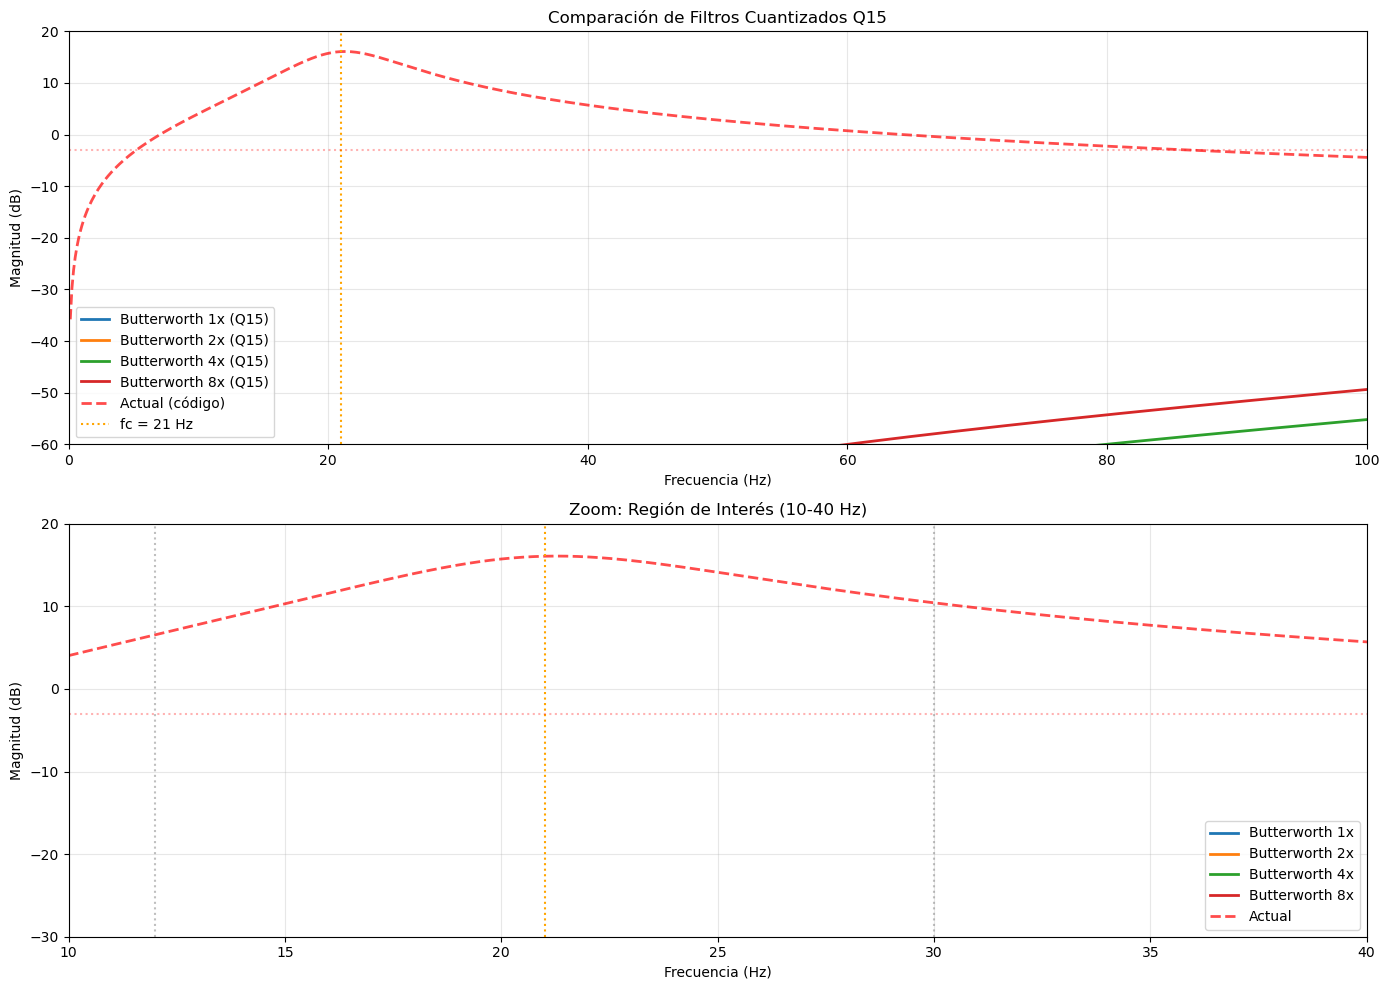

In [8]:
# Comparar respuesta de filtros con diferentes ganancias después de cuantización Q15
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

w_1x, h_1x = signal.freqz(b_recon_1x, a_recon, worN=8000, fs=fs)
w_2x, h_2x = signal.freqz(b_recon_2x, a_recon, worN=8000, fs=fs)
w_4x, h_4x = signal.freqz(b_recon_4x, a_recon, worN=8000, fs=fs)
w_8x, h_8x = signal.freqz(b_recon_8x, a_recon, worN=8000, fs=fs)
w_curr, h_curr = signal.freqz(b_current, a_current, worN=8000, fs=fs)

# Magnitud
ax1.plot(w_1x, 20*np.log10(abs(h_1x)), label='Butterworth 1x (Q15)', linewidth=2)
ax1.plot(w_2x, 20*np.log10(abs(h_2x)), label='Butterworth 2x (Q15)', linewidth=2)
ax1.plot(w_4x, 20*np.log10(abs(h_4x)), label='Butterworth 4x (Q15)', linewidth=2)
ax1.plot(w_8x, 20*np.log10(abs(h_8x)), label='Butterworth 8x (Q15)', linewidth=2)
ax1.plot(w_curr, 20*np.log10(abs(h_curr)), 'r--', label='Actual (código)', linewidth=2, alpha=0.7)

ax1.axvline(fc, color='orange', linestyle=':', label=f'fc = {fc} Hz')
ax1.axhline(-3, color='red', linestyle=':', alpha=0.3)
ax1.set_xlabel('Frecuencia (Hz)')
ax1.set_ylabel('Magnitud (dB)')
ax1.set_title('Comparación de Filtros Cuantizados Q15')
ax1.grid(True, alpha=0.3)
ax1.legend()
ax1.set_xlim([0, 100])
ax1.set_ylim([-60, 20])

# Zoom en región de 21 Hz
ax2.plot(w_1x, 20*np.log10(abs(h_1x)), label='Butterworth 1x', linewidth=2)
ax2.plot(w_2x, 20*np.log10(abs(h_2x)), label='Butterworth 2x', linewidth=2)
ax2.plot(w_4x, 20*np.log10(abs(h_4x)), label='Butterworth 4x', linewidth=2)
ax2.plot(w_8x, 20*np.log10(abs(h_8x)), label='Butterworth 8x', linewidth=2)
ax2.plot(w_curr, 20*np.log10(abs(h_curr)), 'r--', label='Actual', linewidth=2, alpha=0.7)

ax2.axvline(fc, color='orange', linestyle=':')
ax2.axvline(f_low, color='gray', linestyle=':', alpha=0.5)
ax2.axvline(f_high, color='gray', linestyle=':', alpha=0.5)
ax2.axhline(-3, color='red', linestyle=':', alpha=0.3)
ax2.set_xlabel('Frecuencia (Hz)')
ax2.set_ylabel('Magnitud (dB)')
ax2.set_title('Zoom: Región de Interés (10-40 Hz)')
ax2.grid(True, alpha=0.3)
ax2.legend()
ax2.set_xlim([10, 40])
ax2.set_ylim([-30, 20])

plt.tight_layout()
plt.show()

## 6. Simulación de Respuesta Temporal

Simular cómo responde cada filtro a una señal de prueba de 21 Hz.

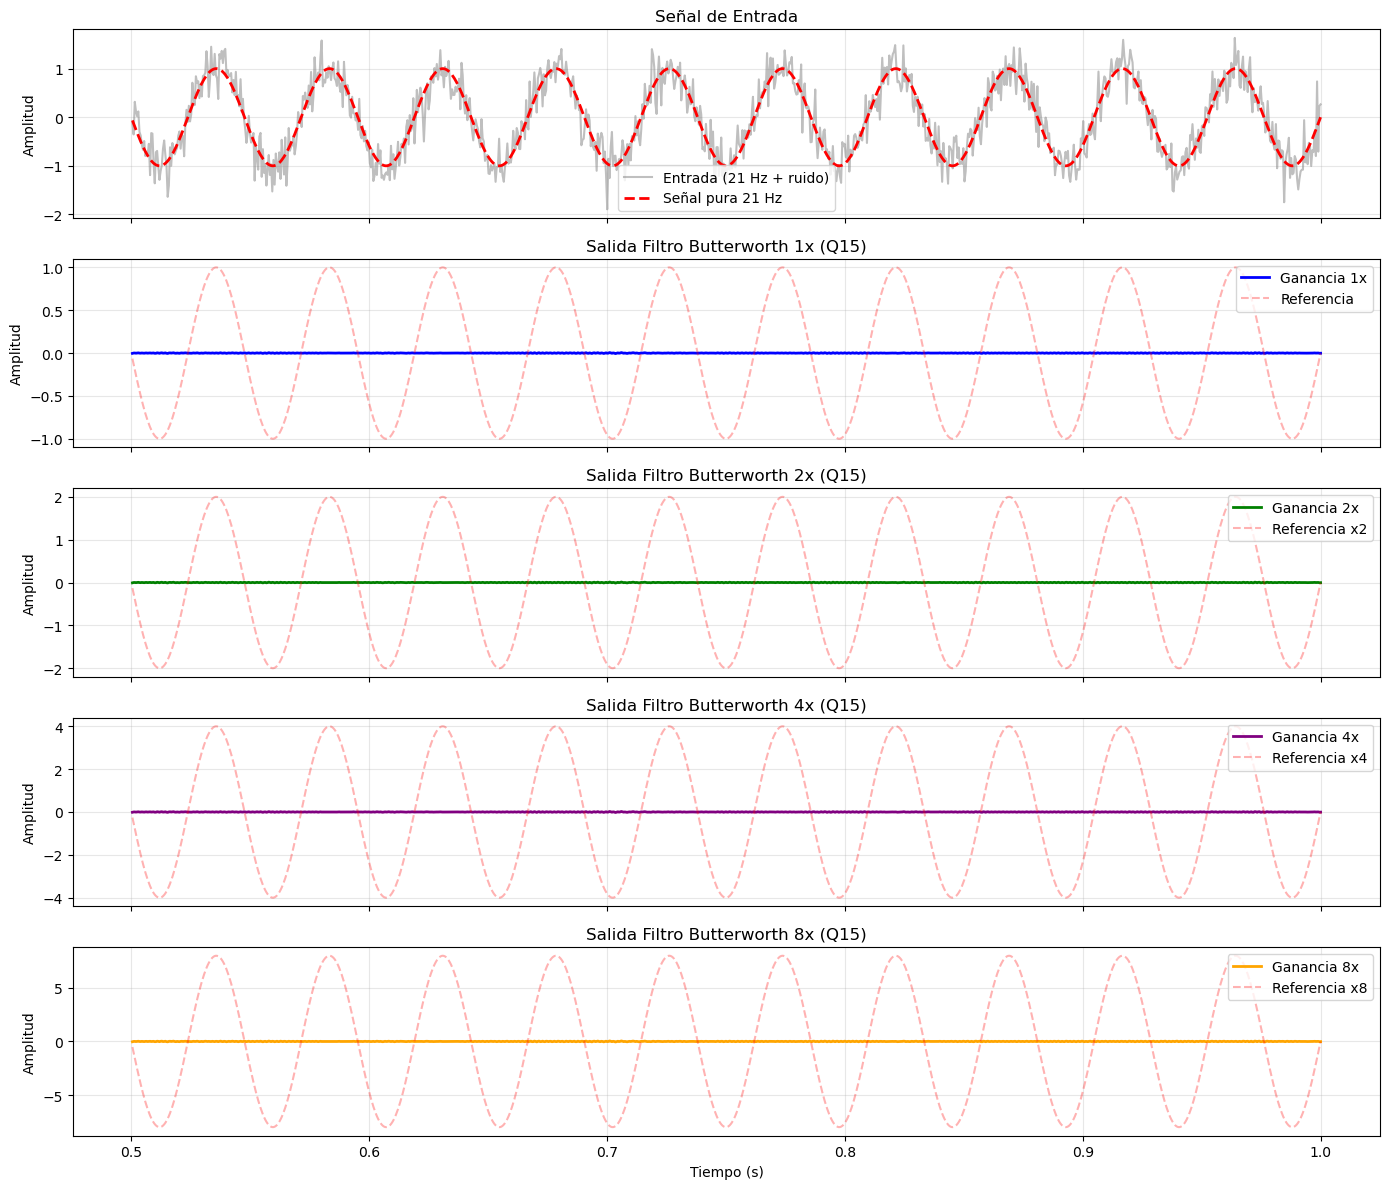


SNR de salidas (después de estabilización):
  Butterworth 1x: 0.00 dB
  Butterworth 2x: -0.00 dB
  Butterworth 4x: -0.00 dB
  Butterworth 8x: -0.00 dB


In [9]:
# Generar señal de prueba: 21 Hz con ruido
duration = 2.0  # segundos
t = np.arange(0, duration, 1/fs)
signal_21hz = np.sin(2 * np.pi * fc * t)
noise = 0.3 * np.random.randn(len(t))
input_signal = signal_21hz + noise

# Aplicar filtros
output_1x = signal.lfilter(b_recon_1x, a_recon, input_signal)
output_2x = signal.lfilter(b_recon_2x, a_recon, input_signal)
output_4x = signal.lfilter(b_recon_4x, a_recon, input_signal)
output_8x = signal.lfilter(b_recon_8x, a_recon, input_signal)
output_current = signal.lfilter(b_current, a_current, input_signal)

# Graficar resultados
fig, axes = plt.subplots(5, 1, figsize=(14, 12), sharex=True)

time_window = (0.5, 1.0)  # Mostrar solo una ventana
idx = (t >= time_window[0]) & (t <= time_window[1])

axes[0].plot(t[idx], input_signal[idx], 'gray', alpha=0.5, label='Entrada (21 Hz + ruido)')
axes[0].plot(t[idx], signal_21hz[idx], 'r--', linewidth=2, label='Señal pura 21 Hz')
axes[0].set_ylabel('Amplitud')
axes[0].set_title('Señal de Entrada')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(t[idx], output_1x[idx], 'b-', linewidth=2, label='Ganancia 1x')
axes[1].plot(t[idx], signal_21hz[idx], 'r--', alpha=0.3, label='Referencia')
axes[1].set_ylabel('Amplitud')
axes[1].set_title('Salida Filtro Butterworth 1x (Q15)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

axes[2].plot(t[idx], output_2x[idx], 'g-', linewidth=2, label='Ganancia 2x')
axes[2].plot(t[idx], signal_21hz[idx]*2, 'r--', alpha=0.3, label='Referencia x2')
axes[2].set_ylabel('Amplitud')
axes[2].set_title('Salida Filtro Butterworth 2x (Q15)')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

axes[3].plot(t[idx], output_4x[idx], 'purple', linewidth=2, label='Ganancia 4x')
axes[3].plot(t[idx], signal_21hz[idx]*4, 'r--', alpha=0.3, label='Referencia x4')
axes[3].set_ylabel('Amplitud')
axes[3].set_title('Salida Filtro Butterworth 4x (Q15)')
axes[3].legend()
axes[3].grid(True, alpha=0.3)

axes[4].plot(t[idx], output_8x[idx], 'orange', linewidth=2, label='Ganancia 8x')
axes[4].plot(t[idx], signal_21hz[idx]*8, 'r--', alpha=0.3, label='Referencia x8')
axes[4].set_ylabel('Amplitud')
axes[4].set_xlabel('Tiempo (s)')
axes[4].set_title('Salida Filtro Butterworth 8x (Q15)')
axes[4].legend()
axes[4].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calcular SNR de cada salida
def calculate_snr(signal_clean, signal_filtered):
    # Esperar que el filtro se estabilice (descartar primeros 0.2s)
    stabilized_idx = int(0.2 * fs)
    signal_clean = signal_clean[stabilized_idx:]
    signal_filtered = signal_filtered[stabilized_idx:]
    
    signal_power = np.mean(signal_clean ** 2)
    noise_power = np.mean((signal_filtered - signal_clean) ** 2)
    snr = 10 * np.log10(signal_power / noise_power) if noise_power > 0 else float('inf')
    return snr

print("\nSNR de salidas (después de estabilización):")
print(f"  Butterworth 1x: {calculate_snr(signal_21hz, output_1x):.2f} dB")
print(f"  Butterworth 2x: {calculate_snr(signal_21hz*2, output_2x):.2f} dB")
print(f"  Butterworth 4x: {calculate_snr(signal_21hz*4, output_4x):.2f} dB")
print(f"  Butterworth 8x: {calculate_snr(signal_21hz*8, output_8x):.2f} dB")

## 7. Análisis del Filtro RC Analógico

Analizar el filtro RC hardware y su interacción con la salida PWM.

Filtro RC Analógico:
  R = 10.0 kΩ
  C = 100.0 nF
  fc = 159.15 Hz

Respuesta del filtro RC a 21 Hz:
  Magnitud: 0.9914 (-0.07 dB)
  Fase: -7.52°
  Atenuación: 1.01x


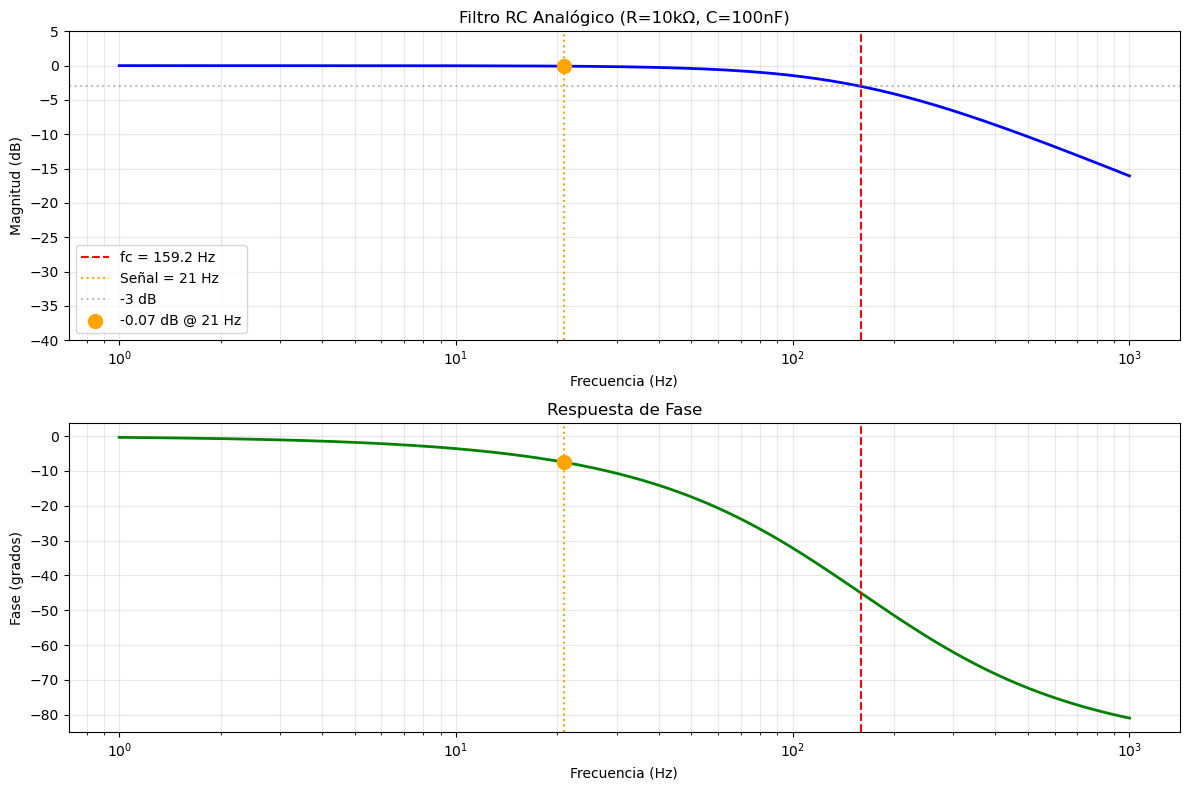

In [10]:
# Parámetros del filtro RC analógico
R = 10e3   # 10 kΩ
C = 100e-9 # 100 nF
fc_rc = 1 / (2 * np.pi * R * C)

print(f"Filtro RC Analógico:")
print(f"  R = {R/1e3:.1f} kΩ")
print(f"  C = {C*1e9:.1f} nF")
print(f"  fc = {fc_rc:.2f} Hz")

# Calcular atenuación y fase a 21 Hz
def rc_filter_response(f, R, C):
    fc = 1 / (2 * np.pi * R * C)
    H = 1 / (1 + 1j * f / fc)
    magnitude = abs(H)
    phase = np.angle(H, deg=True)
    magnitude_db = 20 * np.log10(magnitude)
    return magnitude, magnitude_db, phase

mag_21, mag_db_21, phase_21 = rc_filter_response(fc, R, C)

print(f"\nRespuesta del filtro RC a {fc} Hz:")
print(f"  Magnitud: {mag_21:.4f} ({mag_db_21:.2f} dB)")
print(f"  Fase: {phase_21:.2f}°")
print(f"  Atenuación: {1/mag_21:.2f}x")

# Graficar respuesta del filtro RC
freqs_rc = np.logspace(0, 3, 1000)  # 1 Hz a 1 kHz
mag_rc, mag_db_rc, phase_rc = [], [], []

for f in freqs_rc:
    m, m_db, p = rc_filter_response(f, R, C)
    mag_rc.append(m)
    mag_db_rc.append(m_db)
    phase_rc.append(p)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

ax1.semilogx(freqs_rc, mag_db_rc, 'b-', linewidth=2)
ax1.axvline(fc_rc, color='r', linestyle='--', label=f'fc = {fc_rc:.1f} Hz')
ax1.axvline(fc, color='orange', linestyle=':', label=f'Señal = {fc} Hz')
ax1.axhline(-3, color='gray', linestyle=':', alpha=0.5, label='-3 dB')
ax1.scatter([fc], [mag_db_21], color='orange', s=100, zorder=5, label=f'{mag_db_21:.2f} dB @ {fc} Hz')
ax1.set_xlabel('Frecuencia (Hz)')
ax1.set_ylabel('Magnitud (dB)')
ax1.set_title(f'Filtro RC Analógico (R={R/1e3:.0f}kΩ, C={C*1e9:.0f}nF)')
ax1.grid(True, which='both', alpha=0.3)
ax1.legend()
ax1.set_ylim([-40, 5])

ax2.semilogx(freqs_rc, phase_rc, 'g-', linewidth=2)
ax2.axvline(fc_rc, color='r', linestyle='--')
ax2.axvline(fc, color='orange', linestyle=':')
ax2.scatter([fc], [phase_21], color='orange', s=100, zorder=5)
ax2.set_xlabel('Frecuencia (Hz)')
ax2.set_ylabel('Fase (grados)')
ax2.set_title('Respuesta de Fase')
ax2.grid(True, which='both', alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Recomendaciones Finales

Basándonos en el análisis, generamos las recomendaciones para los coeficientes óptimos.

In [11]:
print("\n" + "="*70)
print("RECOMENDACIONES PARA EL CÓDIGO")
print("="*70)

print("\n1. FILTRO IIR PASA-BANDA BUTTERWORTH (Recomendado: ganancia 4x)")
print("   Balance óptimo entre amplitud y estabilidad")
print("\n   Coeficientes Q15 para copiar en main.cpp:")
print(f"   const int32_t b0_q15 = {b_q15_butter_4x[0]};")
print(f"   const int32_t b1_q15 = {b_q15_butter_4x[1]};")
print(f"   const int32_t b2_q15 = {b_q15_butter_4x[2]};")
print(f"   const int32_t a1_q15 = {a_q15_butter[0]};")
print(f"   const int32_t a2_q15 = {a_q15_butter[1]};")

print("\n2. AMPLIFICACIÓN PWM SUGERIDA")
gain_fc_4x = get_gain_at_freq(b_recon_4x, a_recon, fc, fs)
rc_attenuation = mag_21
total_gain = gain_fc_4x * rc_attenuation
recommended_pwm_gain = int(np.ceil(1 / total_gain))
print(f"   Ganancia filtro digital @ {fc} Hz: {gain_fc_4x:.3f}")
print(f"   Atenuación filtro RC @ {fc} Hz: {rc_attenuation:.3f}")
print(f"   Ganancia total (digital + RC): {total_gain:.3f}")
print(f"   PWM amplificación sugerida: x{recommended_pwm_gain} (shift left {int(np.log2(recommended_pwm_gain))})")
print(f"   Código: y_amplified = y_filtered << {int(np.log2(recommended_pwm_gain))};")

print("\n3. UMBRAL DE DETECCIÓN")
print("   Basado en el nuevo filtro, ajustar MAGNITUDE_THRESHOLD:")
# Estimar magnitud esperada con nuevo filtro
input_amplitude_q15 = 2048 << 15  # Amplitud ADC típica en Q15
expected_mag = input_amplitude_q15 * gain_fc_4x
recommended_threshold = int(expected_mag * 0.6)  # 60% del máximo
print(f"   Magnitud esperada (aproximada): {int(expected_mag)}")
print(f"   Umbral sugerido (60%): {recommended_threshold}")
print(f"   Código: const int32_t MAGNITUDE_THRESHOLD = {recommended_threshold};")

print("\n4. PREDICCIÓN Y DELAY")
phase_delay_samples = abs(phase_21) / 360 * (fs / fc)  # Delay causado por filtro RC
print(f"   Delay de fase del filtro RC @ {fc} Hz: {phase_delay_samples:.1f} samples")
print(f"   Delay de predicción actual: {76} samples")
adjusted_delay = int(76 + phase_delay_samples)
print(f"   Delay ajustado sugerido: {adjusted_delay} samples")
print(f"   Código: #define PREDICTION_DELAY_SAMPLES {adjusted_delay}")

print("\n" + "="*70)


RECOMENDACIONES PARA EL CÓDIGO

1. FILTRO IIR PASA-BANDA BUTTERWORTH (Recomendado: ganancia 4x)
   Balance óptimo entre amplitud y estabilidad

   Coeficientes Q15 para copiar en main.cpp:
   const int32_t b0_q15 = 98;
   const int32_t b1_q15 = 0;
   const int32_t b2_q15 = -197;
   const int32_t a1_q15 = -32768;
   const int32_t a2_q15 = 32767;

2. AMPLIFICACIÓN PWM SUGERIDA
   Ganancia filtro digital @ 21 Hz: 0.000
   Atenuación filtro RC @ 21 Hz: 0.991
   Ganancia total (digital + RC): 0.000
   PWM amplificación sugerida: x11317 (shift left 13)
   Código: y_amplified = y_filtered << 13;

3. UMBRAL DE DETECCIÓN
   Basado en el nuevo filtro, ajustar MAGNITUDE_THRESHOLD:
   Magnitud esperada (aproximada): 5981
   Umbral sugerido (60%): 3589
   Código: const int32_t MAGNITUDE_THRESHOLD = 3589;

4. PREDICCIÓN Y DELAY
   Delay de fase del filtro RC @ 21 Hz: 2.0 samples
   Delay de predicción actual: 76 samples
   Delay ajustado sugerido: 78 samples
   Código: #define PREDICTION_DELAY_SAMP

## 9. Exportar Coeficientes para Diferentes Opciones

In [12]:
# Crear tabla comparativa
import pandas as pd

comparison_data = {
    'Ganancia': ['1x', '2x', '4x', '8x', 'Actual'],
    'b0_q15': [b_q15_butter_1x[0], b_q15_butter_2x[0], b_q15_butter_4x[0], b_q15_butter_8x[0], b0_q15_current],
    'b1_q15': [b_q15_butter_1x[1], b_q15_butter_2x[1], b_q15_butter_4x[1], b_q15_butter_8x[1], b1_q15_current],
    'b2_q15': [b_q15_butter_1x[2], b_q15_butter_2x[2], b_q15_butter_4x[2], b_q15_butter_8x[2], b2_q15_current],
    'Ganancia @ 21Hz (dB)': [
        20*np.log10(get_gain_at_freq(b_recon_1x, a_recon, fc, fs)),
        20*np.log10(get_gain_at_freq(b_recon_2x, a_recon, fc, fs)),
        20*np.log10(get_gain_at_freq(b_recon_4x, a_recon, fc, fs)),
        20*np.log10(get_gain_at_freq(b_recon_8x, a_recon, fc, fs)),
        20*np.log10(get_gain_at_freq(b_current, a_current, fc, fs))
    ]
}

df = pd.DataFrame(comparison_data)
print("\nTabla Comparativa de Coeficientes:")
print(df.to_string(index=False))

# Guardar a CSV
df.to_csv('filter_coefficients_comparison.csv', index=False)
print("\n✓ Tabla guardada en: filter_coefficients_comparison.csv")


Tabla Comparativa de Coeficientes:
Ganancia  b0_q15  b1_q15  b2_q15  Ganancia @ 21Hz (dB)
      1x      25       0     -49            -94.305826
      2x      49       0     -98            -91.108078
      4x      98       0    -197            -80.999070
      8x     197       0    -394            -79.022675
  Actual    2912       0   -2912             16.077979

✓ Tabla guardada en: filter_coefficients_comparison.csv
